In [1]:

import re
import tiktoken
import hashlib

from pathlib import Path


class TextReader:
    
    def __init__(self, file_path, source, text_id, split_pattern=None) -> None:
        self.file_path = Path(file_path)
        self.source = source
        self.text = ""
        self.enc = tiktoken.get_encoding('cl100k_base')
        self.pattern = split_pattern or r"^(?:CHAPTER [IVXLCDM]+\.)\s*\n"
        self.text_id = text_id 


    @staticmethod
    def simple_hash(text: str, length: int = 7) -> str:
        return hashlib.md5(text.encode("utf-8")).hexdigest()[:length]

    def _section_split(self):
        return re.split(self.pattern, self.text, flags=re.IGNORECASE | re.MULTILINE)

    def _chunk_split(self, section: str, max_tokens=1000, overlap=100):
        tokens = self.enc.encode(section)
        chunks = []
        for i in range(0, len(tokens), max_tokens - overlap):
            chunk = self.enc.decode(tokens[i:i+max_tokens])
            chunks.append(chunk)
        return chunks

    def parse_into_chunks(self, max_tokens=800, overlap=100):
        sections = self._section_split()
        all_chunks = []
        for sid, section in enumerate(sections): 
            section_chunks = self._chunk_split(section, max_tokens, overlap)
            for cid, sub in enumerate(section_chunks):
                hash_id = TextReader.simple_hash(sub)
                all_chunks.append(
                    {
                        "id": f"{self.text_id}_{sid+1:02d}_{cid+1:03d}_{hash_id}",
                        "text": sub,
                        "num_tokens": len(self.enc.encode(sub)),
                        "num_chars": len(sub)
                    }
                )
        return all_chunks



class GutenbergReader(TextReader):

    def __init__(self, file_path, text_id) -> None:
        super().__init__(file_path, text_id=text_id, source="gutenberg")


    def _strip_gutenberg(self, text: str) -> str:
        start_match = re.search(r"\*\*\* START OF.*\*\*\*", text)
        end_match = re.search(r"\*\*\* END OF.*\*\*\*", text)
        if start_match and end_match:
            return text[start_match.end(): end_match.start()]
        return text
    
    def parse(self, max_tokens=500, overlap=100):
        book_path = Path(self.file_path)
        raw_text = book_path.read_text(encoding="utf-8")

        self.text = self._strip_gutenberg(raw_text)
        print("Clean word count:", len(self.text.split()))
    
        chunks = self.parse_into_chunks(max_tokens, overlap)
        return chunks

In [2]:
FILE_PATH = "../DATA/alice_in_wonderland.txt"
reader = GutenbergReader(FILE_PATH, "aiw")
chunks = reader.parse(max_tokens=500, overlap=100)

print("Num chunks:", len(chunks))
print("Preview:", chunks[10]["text"][:300])

Clean word count: 26525
Num chunks: 99
Preview:  this), “to go on crying in this way! Stop
this moment, I tell you!” But she went on all the same, shedding
gallons of tears, until there was a large pool all round her, about
four inches deep and reaching half down the hall.

After a time she heard a little pattering of feet in the distance, and
sh


In [3]:
import pandas as pd

df = pd.DataFrame(chunks, columns=['id', 'text', 'num_tokens', 'num_chars'])
df.head()

,id,text,num_tokens,num_chars
0,aiw_01_001_de2f1cf,\n\n[Illustration]\n\n\n\n\nAlice’s Adventures...,159,586
1,aiw_02_001_174ec36,Down the Rabbit-Hole\n\n\nAlice was beginning ...,500,2108
2,aiw_02_002_91bf310,"well was very deep, or she fell very slowly, ...",500,1973
3,aiw_02_003_11c51f3,"\nidea what Latitude was, or Longitude either,...",500,1856
4,aiw_02_004_374f0bd,"zing off, and had just begun to dream that she...",500,2022


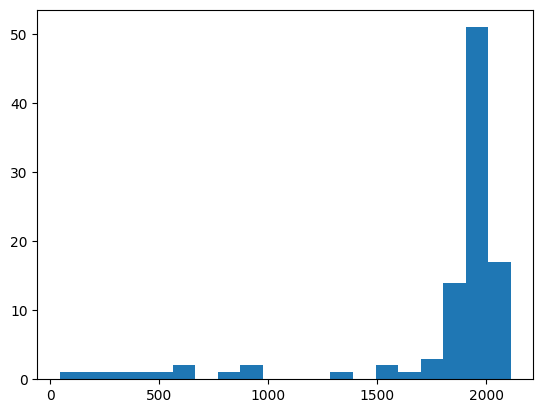

In [4]:
import matplotlib.pyplot as plt

plt.hist(df['num_chars'], bins=20)
plt.show()

In [5]:
import math
import re
from collections import Counter

STOPWORDS = {"the","a","an","and","of","in","to"}
def simple_tokenize(text):
    return [w for w in re.findall(r"\w+", text.lower()) if w not in STOPWORDS]


class BM25Retriever:
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.docs = []
        self.doc_lens = []
        self.avgdl = 0
        self.df = {}
        self.idf = {}
        self.N = 0
        self.ids = []
        self.raw_docs = []

    def build_index(self, chunks):
        self.docs = []
        self.ids = []
        self.df = {}
        self.raw_docs = []

        for chunk in chunks:
            tokens = simple_tokenize(chunk["text"])
            self.docs.append(tokens)
            self.ids.append(chunk["id"])
            self.raw_docs.append(chunk["text"])

        self.N = len(self.docs)
        self.doc_lens = [len(doc) for doc in self.docs]
        self.avgdl = sum(self.doc_lens) / self.N if self.N > 0 else 0

        for doc in self.docs:
            for word in set(doc):
                self.df[word] = self.df.get(word, 0) + 1

        self.idf = {
            word: math.log((self.N - freq + 0.5) / (freq + 0.5) + 1)
            for word, freq in self.df.items()
        }

    def score(self, query_tokens, idx):
        doc = self.docs[idx]
        doc_len = self.doc_lens[idx]
        freqs = Counter(doc)
        score = 0.0
        for term in query_tokens:
            if term not in freqs:
                continue
            df = freqs[term]
            idf = self.idf.get(term, 0)
            numer = df * (self.k1 + 1)
            denom = df + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)
            score += idf * (numer / denom)
        return score

    def search(self, query, topk=7):
        query_tokens = simple_tokenize(query)
        scores = [self.score(query_tokens, i) for i in range(self.N)]
        ranked = sorted(enumerate(scores), key=lambda x: -x[1])[:topk]
        return [{"id": self.ids[i], "text": self.raw_docs[i], "score": s} for i, s in ranked]

    def id_search(self, query: str, topk=7):
        search_results = self.search(query, topk)
        return [c['id'] for c in search_results]

    def cleanup(self):
        self.docs = []
        self.ids = []
        self.df = {}
        self.idf = {}
        self.doc_lens = []
        self.avgdl = 0
        self.N = 0
        self.raw_docs = []
        print("BM25 index cleared.")




In [6]:
bm25 = BM25Retriever()
bm25.build_index(chunks)

In [7]:
bm25.search("alice rabbit")

[{'id': 'aiw_02_001_174ec36',
  'text': 'Down the Rabbit-Hole\n\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into\nthe book her sister was reading, but it had no pictures or\nconversations in it, “and what is the use of a book,” thought Alice\n“without pictures or conversations?”\n\nSo she was considering in her own mind (as well as she could, for the\nhot day made her feel very sleepy and stupid), whether the pleasure of\nmaking a daisy-chain would be worth the trouble of getting up and\npicking the daisies, when suddenly a White Rabbit with pink eyes ran\nclose by her.\n\nThere was nothing so _very_ remarkable in that; nor did Alice think it\nso _very_ much out of the way to hear the Rabbit say to itself, “Oh\ndear! Oh dear! I shall be late!” (when she thought it over afterwards,\nit occurred to her that she ought to have wondered at this, but at the\ntime it all seemed quite natural); but wh

In [8]:
chunks[7]

{'id': 'aiw_02_007_4b8f451',
 'text': ' the table for it, she found she could not possibly reach\nit: she could see it quite plainly through the glass, and she tried her\nbest to climb up one of the legs of the table, but it was too slippery;\nand when she had tired herself out with trying, the poor little thing\nsat down and cried.\n\n“Come, there’s no use in crying like that!” said Alice to herself,\nrather sharply; “I advise you to leave off this minute!” She generally\ngave herself very good advice, (though she very seldom followed it),\nand sometimes she scolded herself so severely as to bring tears into\nher eyes; and once she remembered trying to box her own ears for having\ncheated herself in a game of croquet she was playing against herself,\nfor this curious child was very fond of pretending to be two people.\n“But it’s no use now,” thought poor Alice, “to pretend to be two\npeople! Why, there’s hardly enough of me left to make _one_ respectable\nperson!”\n\nSoon her eye fell

In [9]:
# Golden data for testing - Preparation. 

%reload_ext dotenv
%dotenv

import json
import os
from openai import OpenAI
from tqdm.auto import tqdm
from string import Template

gt_prompt_template = Template(""" 
You are emulating realistic book readers with diverse reading habits. 
The readers have mostly read the book and are now trying to recall, clarify, 
or explore details by searching within the book. 
Some are precise, some are vague, some type in full questions, 
and others use only a couple of words or short phrases.


TASK:
Formulate exactly 5 distinct search queries that a reader might ask 
based only on the following 'Record' (viz. a chunked information from the book/content).

Record:

id: $id
text: $text
num_tokens: $num_tokens
num_chars: $num_chars
                              
HARD CONSTRAINTS:
- Use ONLY details present in the record (no external knowledge).
- Max 15 words per query.
- Each query must sound like something a real book reader would type.
- Ensure a MIX of query STYLES and INTENT across the 5:
    • 1 short keyword-style query (2–4 words).  Occasionally, this may be purely keyword-based.
    • 1 natural-language full question.
    • 1 phrase-like query (fragment, not a full sentence).
    • 1 detail-oriented recall query (who/what/where).
    • 1 deeper reflective or interpretive query (asking about meaning, emotion, theme, or motivation).
- Avoid reusing the same key noun/adjective across queries; vary wording and style.
- At least one query must be **thoughtful and reflective** (not just factual or keyword-based).
- Queries should sound like a human reader’s questions, not summaries.
- Do NOT always output the 5 query types in the same sequence. Randomly vary the order 
  so the set looks natural and less templated.

OUTPUT FORMAT:
Return only a JSON array of 5 strings, with no extra text:
[
  "query_1",
  "query_2",
  "query_3",
  "query_4",
  "query_5"
]
""")


class GoldenDataGenerator:
    
    def __init__(self) -> None:
        self.llm = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        self.results = {}
        self.aiw_gt = []

    def generate_questions(self, doc):
        gt_prompt = gt_prompt_template.substitute(**doc)

        response = self.llm.chat.completions.create(
            model='gpt-4o-mini',
            messages=[{"role": "user", "content": gt_prompt}]
        )

        json_response = response.choices[0].message.content
        return json_response
    

    def bulk_generate(self, chunks):
      for doc in tqdm(chunks):
          doc_id = doc['id']
          if doc_id in self.results:
              continue
          try:
              res = self.generate_questions(doc) or "[]"
              self.results[doc['id']] = json.loads(res)
          except Exception as e:
              print("Error for doc:", doc['id'], e)


    def save(self, out_path="../DATA/GT/aiw_golden_data.json"):
        with open(out_path, "w") as f:
            json.dump(self.results, f, indent=2)
        print(f"Saved {len(self.results)} records to {out_path}")


    def load(self, in_path="../DATA/aiw_golden_data.json"):
      with open("../DATA/GT/aiw_golden_data.json", "r") as f:
          res = json.load(f)

          for cid, queries in res.items():
              for q in queries:
                  self.aiw_gt.append(
                      {
                          'gold_id': cid,
                          'query': q
                      }
                  )

    def get_golden_data(self):
        return self.aiw_gt



/Users/sethurama/DEV/LM/book-mate/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# gen = GoldenDataGenerator()
# gen.generate_questions(chunks[7])

In [11]:
gen = GoldenDataGenerator()
# gen.bulk_generate(chunks)
# gen.save()  
gen.load()
aiw_gt = gen.get_golden_data()

In [12]:
aiw_gt[:10]

[{'gold_id': 'aiw_01_001_de2f1cf', 'query': 'Mad Tea-Party chapter'},
 {'gold_id': 'aiw_01_001_de2f1cf',
  'query': 'What happens in the Pool of Tears?'},
 {'gold_id': 'aiw_01_001_de2f1cf', 'query': 'Caucus-Race outcome'},
 {'gold_id': 'aiw_01_001_de2f1cf', 'query': 'Who sends in Bill?'},
 {'gold_id': 'aiw_01_001_de2f1cf',
  'query': 'What does the tea party symbolize?'},
 {'gold_id': 'aiw_02_001_174ec36',
  'query': "Alice's curiosity about the Rabbit"},
 {'gold_id': 'aiw_02_001_174ec36',
  'query': "Why did Alice think the Rabbit's actions were natural?"},
 {'gold_id': 'aiw_02_001_174ec36', 'query': 'falling down the rabbit-hole'},
 {'gold_id': 'aiw_02_001_174ec36',
  'query': 'Who does Alice sit with at the beginning?'},
 {'gold_id': 'aiw_02_001_174ec36',
  'query': 'Theme of boredom in the opening scene'}]

In [13]:
# Evaluation of search quality

from collections import defaultdict

class SearchEvaluator:

    def __init__(self, chunks, searcher) -> None:
        self.chunks = chunks
        self.searcher = searcher
        self.results = []

    @staticmethod
    def hit_rate_at_k(res_ids, gold_id, k=5):
        return 1.0 if gold_id in res_ids[:k] else 0.0


    @staticmethod
    def mrr_at_k(res_ids, gold_id, k=5):
        for i, res_id in enumerate(res_ids[:k], start=1):
            if res_id == gold_id:
                return 1.0 / i 
        return 0.0

    @staticmethod
    def calculate_metrics(results, k_values=[5, 7]):

        if not results:
            return {f"hit_rate_at_{k}": 0.0 for k in k_values} | {f"mrr_at_{k}": 0.0 for k in k_values}
        
        metrics = defaultdict(list)

        for result in results:
            res_ids = result.get('chunk_ids')
            gold_id = result.get('gold_id')

            for k in k_values:
                metrics[f'hit_rate_at_{k}'].append(SearchEvaluator.hit_rate_at_k(res_ids, gold_id, k))
                metrics[f'mrr_at_{k}'].append(SearchEvaluator.mrr_at_k(res_ids, gold_id, k))

        avg_metrics = {}
        for metric, values in metrics.items():
            avg_metrics[metric] = sum(values) / len(values) if values else 0.0

        avg_metrics['total_queries'] = len(results)

        return avg_metrics
    


    def evaluate(self):
        results = []
        self.searcher.build_index(self.chunks)

        for item in aiw_gt:
            gold_id = item['gold_id']
            query = item['query']

            res = self.searcher.id_search(query)
            results.append(
                {
                    'gold_id': gold_id,
                    'chunk_ids': res
                }
            )
        metrics = SearchEvaluator.calculate_metrics(results)
        return metrics

    


In [14]:
bm25 = BM25Retriever()
bm25_evaluator = SearchEvaluator(chunks, bm25)
bm25_metrics = bm25_evaluator.evaluate()
print(json.dumps(bm25_metrics, indent=2))

{
  "hit_rate_at_5": 0.793939393939394,
  "mrr_at_5": 0.5865319865319865,
  "hit_rate_at_7": 0.8282828282828283,
  "mrr_at_7": 0.5918229918229918,
  "total_queries": 495
}


In [15]:
# Vector Search 
from qdrant_client import QdrantClient, models
from sentence_transformers import SentenceTransformer

class SemanticRetriever:

    COLLECTION = "book_chunks"

    def __init__(self, transformer="BAAI/bge-small-en") -> None:
        super().__init__()
        self.embedder = SentenceTransformer(transformer)
        self.qdrant = QdrantClient("localhost", port=6333)

        self.embeddings = []
        self.ids = []

    def embed_batch(self, chunks):
        texts = [c["text"] for c in chunks]
        vecs = self.embedder.encode(texts, normalize_embeddings=True).tolist()
        return vecs


    def build_index(self, chunks):

        vectors = self.embed_batch(chunks)
        print("Vector shape:", len(vectors), len(vectors[0]))

        if not self.qdrant.collection_exists(SemanticRetriever.COLLECTION):
            self.qdrant.create_collection(
                collection_name=SemanticRetriever.COLLECTION,
                vectors_config=models.VectorParams(
                    size=len(vectors[0]),
                    distance=models.Distance.COSINE
                )
            )

        # Upsert points
        self.qdrant.upsert(
            collection_name=SemanticRetriever.COLLECTION,
            points=[
                models.PointStruct(
                    id=i,
                    vector=vectors[i],
                    payload=chunks[i]
                )
                for i in range(len(chunks))
            ]
        )
        print(f" ## Inserted: {len(chunks)} chunks into Qdrant")

    def search(self, query, topk=7):
        vec = self.embedder.encode([query], normalize_embeddings=True)[0].tolist()
        hits = self.qdrant.search(collection_name=SemanticRetriever.COLLECTION, query_vector=vec, limit=topk)
        return [{"id": h.payload["id"], "text": h.payload["text"], "score": h.score} for h in hits]

    def id_search(self, query: str, topk=7):
        search_results = self.search(query, topk)
        return [c["id"] for c in search_results]

    def cleanup(self):
        self.embeddings = []
        self.ids = []
        self.qdrant.delete_collection(SemanticRetriever.COLLECTION)
        print("Semantic index cleared.")

In [16]:
vec = SemanticRetriever()
vec.cleanup()  # Clear previous index if any to avoid dimension mismatch
vec.build_index(chunks)
vec_evaluator = SearchEvaluator(chunks, vec)
vec_metrics = vec_evaluator.evaluate()
print(json.dumps(vec_metrics, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:12: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.8.3. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  self.qdrant = QdrantClient("localhost", port=6333)


Semantic index cleared.
Vector shape: 99 384
 ## Inserted: 99 chunks into Qdrant
Vector shape: 99 384
 ## Inserted: 99 chunks into Qdrant


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:53: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.qdrant.search(collection_name=SemanticRetriever.COLLECTION, query_vector=vec, limit=topk)


{
  "hit_rate_at_5": 0.5777777777777777,
  "mrr_at_5": 0.40898989898989896,
  "hit_rate_at_7": 0.6363636363636364,
  "mrr_at_7": 0.4181770081770082,
  "total_queries": 495
}


In [17]:
from collections import defaultdict

class FusionRetriever:

    def __init__(self, transformer="BAAI/bge-small-en", alpha=0.7) -> None:
        self.bm25 = BM25Retriever()
        self.vec = SemanticRetriever(transformer=transformer)
        self.alpha = alpha

    def build_index(self, chunks):
        self.bm25.build_index(chunks)
        self.vec.build_index(chunks)

    @staticmethod
    def rrf_fusion(bm25_results, embed_results, k=7, c=60):
        """
        Fuse BM25 + Embedding rankings using Reciprocal Rank Fusion (RRF).
        
        Returns:
            list of chunk_ids (top-k fused)
        """
        ranks = defaultdict(float)

        # BM25 contribution
        for rank, chunk in enumerate(bm25_results, start=1):
            ranks[chunk["id"]] += 1.0 / (c + rank)

        # Embedding contribution
        for rank, chunk in enumerate(embed_results, start=1):
            ranks[chunk["id"]] += 1.0 / (c + rank)

        # Sort by fused score
        fused = sorted(ranks.items(), key=lambda x: -x[1])[:k]
        return [cid for cid, _ in fused]

    def weighted_fusion(self, bm25_results, embed_results, topk=7):
        scores = defaultdict(float)
        for rank, c in enumerate(bm25_results, start=1):
            scores[c["id"]] += self.alpha * (1.0 / rank)
        for rank, c in enumerate(embed_results, start=1):
            scores[c["id"]] += (1 - self.alpha) * (1.0 / rank)
        return [cid for cid, _ in sorted(scores.items(), key=lambda x: -x[1])[:topk]]
    
    def id_search(self, query: str, topk=7):
        bm25_results = self.bm25.search(query, topk * 2)   
        embed_results = self.vec.search(query, topk * 2) 
        return self.weighted_fusion(bm25_results, embed_results)


In [18]:
fusion_retriever = FusionRetriever()
fusion_evaluator = SearchEvaluator(chunks, fusion_retriever)
fusion_metrics = fusion_evaluator.evaluate()
print(json.dumps(fusion_metrics, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:12: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.8.3. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  self.qdrant = QdrantClient("localhost", port=6333)


Vector shape: 99 384
 ## Inserted: 99 chunks into Qdrant


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:53: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.qdrant.search(collection_name=SemanticRetriever.COLLECTION, query_vector=vec, limit=topk)


{
  "hit_rate_at_5": 0.8101010101010101,
  "mrr_at_5": 0.5944444444444444,
  "hit_rate_at_7": 0.8585858585858586,
  "mrr_at_7": 0.601996151996152,
  "total_queries": 495
}


In [19]:
print("BM25 Search Metrics:" , json.dumps(bm25_metrics, indent=2))
print("Vector Search Metrics", json.dumps(vec_metrics, indent=2))
print("Fusion Search Metrics", json.dumps(fusion_metrics, indent=2))

BM25 Search Metrics: {
  "hit_rate_at_5": 0.793939393939394,
  "mrr_at_5": 0.5865319865319865,
  "hit_rate_at_7": 0.8282828282828283,
  "mrr_at_7": 0.5918229918229918,
  "total_queries": 495
}
Vector Search Metrics {
  "hit_rate_at_5": 0.5777777777777777,
  "mrr_at_5": 0.40898989898989896,
  "hit_rate_at_7": 0.6363636363636364,
  "mrr_at_7": 0.4181770081770082,
  "total_queries": 495
}
Fusion Search Metrics {
  "hit_rate_at_5": 0.8101010101010101,
  "mrr_at_5": 0.5944444444444444,
  "hit_rate_at_7": 0.8585858585858586,
  "mrr_at_7": 0.601996151996152,
  "total_queries": 495
}


In [20]:
vec2 = SemanticRetriever(transformer="sentence-transformers/multi-qa-mpnet-base-cos-v1")
vec2.cleanup()  # Clear previous index if any to avoid dimension mismatch
vec2.build_index(chunks)
vec2_evaluator = SearchEvaluator(chunks, vec2)
vec2_metrics = vec2_evaluator.evaluate()
print(json.dumps(vec2_metrics, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:12: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.8.3. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  self.qdrant = QdrantClient("localhost", port=6333)


Semantic index cleared.
Vector shape: 99 768
 ## Inserted: 99 chunks into Qdrant
Vector shape: 99 768
 ## Inserted: 99 chunks into Qdrant


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:53: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.qdrant.search(collection_name=SemanticRetriever.COLLECTION, query_vector=vec, limit=topk)


{
  "hit_rate_at_5": 0.6707070707070707,
  "mrr_at_5": 0.4751515151515151,
  "hit_rate_at_7": 0.7292929292929293,
  "mrr_at_7": 0.48453102453102453,
  "total_queries": 495
}


In [21]:
fusion_retriever = FusionRetriever(transformer="sentence-transformers/multi-qa-mpnet-base-cos-v1", alpha=0.5)
fusion_evaluator = SearchEvaluator(chunks, fusion_retriever)
fusion_metrics = fusion_evaluator.evaluate()
print(json.dumps(fusion_metrics, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:12: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.8.3. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  self.qdrant = QdrantClient("localhost", port=6333)


Vector shape: 99 768
 ## Inserted: 99 chunks into Qdrant


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:53: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.qdrant.search(collection_name=SemanticRetriever.COLLECTION, query_vector=vec, limit=topk)


{
  "hit_rate_at_5": 0.8141414141414142,
  "mrr_at_5": 0.6090909090909091,
  "hit_rate_at_7": 0.8444444444444444,
  "mrr_at_7": 0.6138528138528138,
  "total_queries": 495
}


In [22]:
fusion_retriever = FusionRetriever(transformer="sentence-transformers/multi-qa-mpnet-base-cos-v1", alpha=0.5)
fusion_evaluator = SearchEvaluator(chunks, fusion_retriever)
fusion_metrics = fusion_evaluator.evaluate()
print(json.dumps(fusion_metrics, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:12: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.8.3. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  self.qdrant = QdrantClient("localhost", port=6333)


Vector shape: 99 768
 ## Inserted: 99 chunks into Qdrant


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_98018/598598054.py:53: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.qdrant.search(collection_name=SemanticRetriever.COLLECTION, query_vector=vec, limit=topk)


{
  "hit_rate_at_5": 0.8141414141414142,
  "mrr_at_5": 0.6090909090909091,
  "hit_rate_at_7": 0.8444444444444444,
  "mrr_at_7": 0.6138528138528138,
  "total_queries": 495
}
